# 1. Загрузка данных. Разбиение на обучающую и тестовую выборку

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
import numpy as np
from math import sqrt

In [2]:
df = pd.read_csv(r"D:\MachineLearning\data\trip_duration_processed.csv")

In [3]:
df = df.drop(['Unnamed: 0', 'vendor_id_2'], axis=1)

Целевой признак: trip_duration

In [4]:
df.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_day,trip_month,trip_hour,distance,trip_duration,vendor_id_1
0,1,-73.953918,40.778873,-73.963875,40.771164,1,2,16,0.012592,400,0
1,2,-73.988312,40.731743,-73.994751,40.694931,5,3,23,0.037371,1100,1
2,2,-73.997314,40.721458,-73.948029,40.774918,7,2,17,0.072712,1635,0
3,6,-73.961670,40.759720,-73.956779,40.780628,2,1,9,0.021473,1141,0
4,1,-74.017120,40.708469,-73.988182,40.740631,3,2,6,0.043264,848,1


Соотношение 80% / 20%, с перемешиванием

In [5]:
y = df['trip_duration']
X = df.drop(['trip_duration'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, shuffle=True)

# 2. Решаем задачу регрессии

## 2.1 Простая линейная регрессия

In [6]:
lm = LinearRegression()
lm

LinearRegression()

### Возьмём предиктор distance и обучим модель

In [7]:
lm.fit(X_train['distance'].values.reshape(-1, 1), y_train)

LinearRegression()

In [8]:
def calc_scores(y, y_pred):
    scores = [
        mean_absolute_error(y, y_pred),
        mean_squared_error(y, y_pred),
        sqrt(mean_squared_error(y, y_pred)),
        mean_absolute_percentage_error(y, y_pred),
        r2_score(y, y_pred)
    ]
    scores = map(lambda x: round(x, 3), scores)
    return scores

In [9]:
def create_scores_table(train_scores, test_scores):
    columns = ['Train sample', 'Test sample']
    columns_with_scores = zip(columns, [train_scores, test_scores])
    df = pd.DataFrame({column: scores for column, scores in columns_with_scores})
    indexes = ['MAE', 'MSE', 'RMSE', 'MAPE', 'R^2']
    df.index = indexes
    return df

In [10]:
def calc_test_train_scores(model):
    y_test_pred = model.predict(X_test['distance'].values.reshape(-1, 1))
    test_scores = calc_scores(y_test, y_test_pred)
    
    y_train_pred = model.predict(X_train['distance'].values.reshape(-1, 1))
    train_scores = calc_scores(y_train, y_train_pred)

    return [test_scores, train_scores]

### Вычислим метрики на обучающей и тестовой выборке

In [11]:
scoreses = calc_test_train_scores(lm)

In [12]:
scores_table = create_scores_table(scoreses[0], scoreses[1])
scores_table

,Train sample,Test sample
MAE,220.236,220.763
MSE,85522.646,85844.028
RMSE,292.443,292.992
MAPE,0.540,0.564
R^2,0.481,0.478


### Посмотрим на свободный член и вес модели

In [13]:
pd.DataFrame([round(lm.coef_[0], 2), round(lm.intercept_, 2)], index=['coefficient', 'intercept'], columns=['Linear Regerssion'])

,Linear Regerssion
coefficient,17923.51
intercept,261.77


### Построим график линейной модели

<Axes: xlabel='distance', ylabel='trip_duration'>

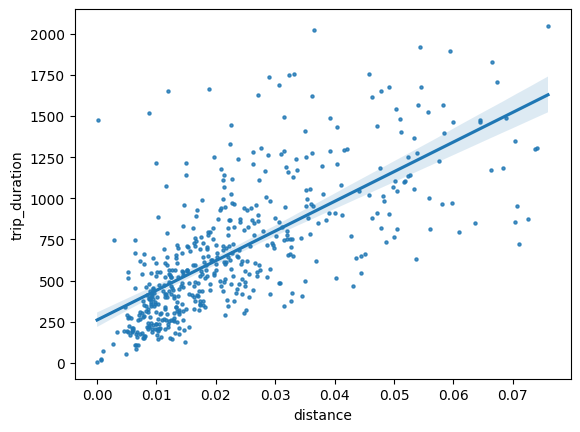

In [14]:
sns.regplot(x=X_test['distance'][:500], y=y_test[:500], scatter_kws={'s': 5})

### Построим график остатков

<Axes: xlabel='distance', ylabel='trip_duration'>

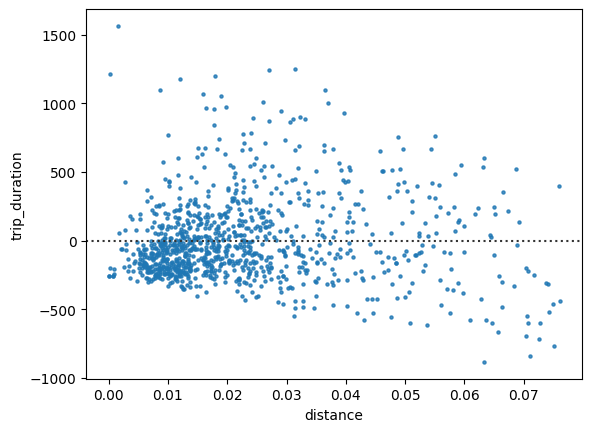

In [15]:
sns.residplot(x=X_test['distance'][:1000], y=y_test[:1000], scatter_kws={'s': 5})

Видим, что у многих объектов большая разница между предсказываемым значением и истинным

### Рассмотрим все остальные предикторы для простой линейной регрессии

In [16]:
for predictor in df.drop(['trip_duration'], axis=1).columns:
    y = df['trip_duration']
    X = df.drop(['trip_duration'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)
    lm1 = LinearRegression()
    lm1.fit(X_train[predictor].values.reshape(-1, 1), y_train)
    y_pred = lm1.predict(X_test[predictor].values.reshape(-1, 1))
    print(pd.DataFrame(calc_scores(y_test, y_pred), index=['MAE', 'MSE', 'RMSE', 'MAPE', 'R^2'], columns=[predictor]))
    print()

      passenger_count
MAE           325.336
MSE        166534.352
RMSE          408.086
MAPE            1.025
R^2            -0.000

      pickup_longitude
MAE            322.808
MSE         163764.273
RMSE           404.678
MAPE             1.035
R^2              0.001

      pickup_latitude
MAE           321.687
MSE        163010.099
RMSE          403.745
MAPE            1.045
R^2             0.006

      dropoff_longitude
MAE             323.373
MSE          164521.161
RMSE            405.612
MAPE              1.018
R^2               0.000

      dropoff_latitude
MAE            320.774
MSE         161991.142
RMSE           402.481
MAPE             1.016
R^2              0.014

        trip_day
MAE      323.486
MSE   164510.465
RMSE     405.599
MAPE       1.003
R^2        0.001

      trip_month
MAE      324.476
MSE   165363.781
RMSE     406.649
MAPE       1.044
R^2        0.003

       trip_hour
MAE      323.457
MSE   164159.450
RMSE     405.166
MAPE       1.015
R^2        0.003

  

### Вывод: лучше всего простая модель показывает себя с предиктором distance. Потому возьмём его для моделей Lasso и Ridge

# 2.2 Lasso

In [17]:
parameters = {'alpha': np.arange(0.1, 1, 0.1)}

### Grid search

In [18]:
lasso_optimal = GridSearchCV(Lasso(), parameters, n_jobs=-1).fit(X_train['distance'].values.reshape(-1, 1), y_train)
lasso_optimal.best_params_

{'alpha': np.float64(0.1)}

### Randomized search

In [19]:
lasso_optimal = RandomizedSearchCV(Lasso(), parameters, n_jobs=-1).fit(X_train['distance'].values.reshape(-1, 1), y_train)
lasso_optimal.best_params_

D:\MachineLearning\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'alpha': np.float64(0.1)}

### Optuna

In [20]:
import optuna

D:\MachineLearning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)
    model = Lasso(alpha=alpha).fit(X_train['distance'].values.reshape(-1, 1), y_train)
    y_pred = model.predict(X_test['distance'].values.reshape(-1, 1))
    return mean_squared_error(y_test, y_pred)

In [22]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_prams_lasso_optuna = study.best_params

[I 2025-03-13 10:49:18,814] A new study created in memory with name: no-name-e0a3cbd0-3f30-416f-8259-913af833d5f3
C:\Users\Denis\AppData\Local\Temp\ipykernel_22360\2953415244.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)
[I 2025-03-13 10:49:18,845] Trial 0 finished with value: 164704.23458575798 and parameters: {'alpha': 8.099666915494327}. Best is trial 0 with value: 164704.23458575798.
C:\Users\Denis\AppData\Local\Temp\ipykernel_22360\2953415244.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)
[I 2025-03-13 10:49:18,908] Trial 1 finished with value: 85587

### Создаём модели с оптимальными гипермараметрами

In [23]:
lasso = Lasso(alpha=0.1).fit(X_train['distance'].values.reshape(-1, 1), y_train)
lasso

Lasso(alpha=0.1)

In [24]:
lasso_with_optuna = Lasso(alpha=best_prams_lasso_optuna['alpha']).fit(X_train['distance'].values.reshape(-1, 1), y_train)
lasso_with_optuna

Lasso(alpha=1.0003914618603726e-05)

### Сравниваем модели с гиперпараметрами, подобранными Optuna и Grid, Randomized search

In [25]:
lasso_scoreses = calc_test_train_scores(lasso)
lasso_scores_table = create_scores_table(lasso_scoreses[0], lasso_scoreses[1])
lasso_scores_table

,Train sample,Test sample
MAE,220.803,220.973
MSE,85643.319,85627.093
RMSE,292.649,292.621
MAPE,0.556,0.552
R^2,0.480,0.480


In [26]:
lasso_optuna_scoreses = calc_test_train_scores(lasso_with_optuna)
lasso_optuna_scores_table = create_scores_table(lasso_optuna_scoreses[0], lasso_optuna_scoreses[1])
lasso_optuna_scores_table

,Train sample,Test sample
MAE,220.150,220.332
MSE,85587.484,85586.466
RMSE,292.553,292.552
MAPE,0.547,0.544
R^2,0.480,0.480


# 2.3 Ridge

In [27]:
parameters_ridge = {'alpha': np.arange(0.1, 1, 0.1)}

### Grid search

In [28]:
ridge_optimal = GridSearchCV(Ridge(), parameters_ridge, n_jobs=-1).fit(X_train['distance'].values.reshape(-1, 1), y_train)
ridge_optimal.best_params_

{'alpha': np.float64(0.1)}

### Randomized search

In [29]:
ridge_optimal = RandomizedSearchCV(Ridge(), parameters, n_jobs=-1).fit(X_train['distance'].values.reshape(-1, 1), y_train)
ridge_optimal.best_params_

D:\MachineLearning\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'alpha': np.float64(0.1)}

### Optuna

In [30]:
import optuna

In [31]:
def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)
    model = Ridge(alpha=alpha).fit(X_train['distance'].values.reshape(-1, 1), y_train)
    y_pred = model.predict(X_test['distance'].values.reshape(-1, 1))
    return mean_squared_error(y_test, y_pred)

In [32]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_prams_ridge_optuna = study.best_params

[I 2025-03-13 10:49:26,301] A new study created in memory with name: no-name-b0a4f8c5-94a8-40aa-97d5-6834120bb919
C:\Users\Denis\AppData\Local\Temp\ipykernel_22360\2046971770.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)
[I 2025-03-13 10:49:26,327] Trial 0 finished with value: 85587.52875030151 and parameters: {'alpha': 0.007966054667300231}. Best is trial 0 with value: 85587.52875030151.
C:\Users\Denis\AppData\Local\Temp\ipykernel_22360\2046971770.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)
[I 2025-03-13 10:49:26,358] Trial 1 finished with value: 8558

### Создаём модели с оптимальными гипермараметрами

In [33]:
ridge = Ridge(alpha=0.1).fit(X_train['distance'].values.reshape(-1, 1), y_train)
ridge

Ridge(alpha=0.1)

In [34]:
ridge_with_optuna = Ridge(alpha=best_prams_ridge_optuna['alpha']).fit(X_train['distance'].values.reshape(-1, 1), y_train)
ridge_with_optuna

Ridge(alpha=1.0011286495341268e-05)

## Сравниваем модели с гиперпараметрами, подобранными Grid, Randomized search и Optuna 

### Ridge с гиперпараметрами, подобранными Grid и Randomized

In [35]:
ridge_scoreses = calc_test_train_scores(ridge)
ridge_scores_table = create_scores_table(ridge_scoreses[0], ridge_scoreses[1])
ridge_scores_table

,Train sample,Test sample
MAE,220.173,220.354
MSE,85588.116,85586.522
RMSE,292.554,292.552
MAPE,0.547,0.544
R^2,0.480,0.480


### Ridge с гиперпараметрами, подобранными Optuna

In [36]:
ridge_optuna_scoreses = calc_test_train_scores(ridge_with_optuna)
ridge_optuna_scores_table = create_scores_table(ridge_optuna_scoreses[0], ridge_optuna_scoreses[1])
ridge_optuna_scores_table

,Train sample,Test sample
MAE,220.150,220.332
MSE,85587.482,85586.466
RMSE,292.553,292.552
MAPE,0.547,0.544
R^2,0.480,0.480


# 2.4 ElasticNet

In [37]:
parameters = {'alpha': np.arange(0.1, 1, 0.1), 'l1_ratio': np.arange(0.1, 1, 0.1)}

### Grid search

In [38]:
elastic_optimal_grid = GridSearchCV(ElasticNet(), parameters, n_jobs=-1).fit(X_train['distance'].values.reshape(-1, 1), y_train)
elastic_optimal_grid.best_params_

{'alpha': np.float64(0.1), 'l1_ratio': np.float64(0.9)}

### Randomized search

In [39]:
elastic_optimal_rand = RandomizedSearchCV(ElasticNet(), parameters, n_jobs=-1).fit(X_train['distance'].values.reshape(-1, 1), y_train)
elastic_optimal_rand.best_params_

{'l1_ratio': np.float64(0.8), 'alpha': np.float64(0.30000000000000004)}

### Optuna

In [40]:
import optuna

In [41]:
def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)
    l1_ratio = trial.suggest_loguniform('l1_ratio', 0.1, 1)
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(X_train['distance'].values.reshape(-1, 1), y_train)
    y_pred = model.predict(X_test['distance'].values.reshape(-1, 1))
    return mean_squared_error(y_test, y_pred)

In [42]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_prams_elastic_optuna = study.best_params
print(best_prams_elastic_optuna)

[I 2025-03-13 10:49:39,925] A new study created in memory with name: no-name-8d934ead-eb60-42c3-886d-e4db5d07ccb1
C:\Users\Denis\AppData\Local\Temp\ipykernel_22360\2458381160.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)
C:\Users\Denis\AppData\Local\Temp\ipykernel_22360\2458381160.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_ratio = trial.suggest_loguniform('l1_ratio', 0.1, 1)
[I 2025-03-13 10:49:39,973] Trial 0 finished with value: 164449.53271532024 and parameters: {'alpha': 0.1706416808533276, 'l1_ratio': 0.11386040087462192}. Best is trial 0 with value: 164449.53271532024.
C:\Users\Denis\AppData\Lo

{'alpha': 9.083615532729859e-05, 'l1_ratio': 0.9954758234069221}


### Создаём модели с оптимальными гипермараметрами

In [43]:
elastic_with_grid = ElasticNet(alpha=elastic_optimal_grid.best_params_['alpha'], l1_ratio=elastic_optimal_grid.best_params_['l1_ratio']).fit(X_train['distance'].values.reshape(-1, 1), y_train)
elastic_with_grid

ElasticNet(alpha=np.float64(0.1), l1_ratio=np.float64(0.9))

In [44]:
elastic_with_rand = ElasticNet(alpha=elastic_optimal_rand.best_params_['alpha'], l1_ratio=elastic_optimal_rand.best_params_['l1_ratio']).fit(X_train['distance'].values.reshape(-1, 1), y_train)
elastic_with_rand

ElasticNet(alpha=np.float64(0.30000000000000004), l1_ratio=np.float64(0.8))

In [45]:
elastic_with_optuna = ElasticNet(alpha=best_prams_elastic_optuna['alpha'], l1_ratio=best_prams_elastic_optuna['l1_ratio']).fit(X_train['distance'].values.reshape(-1, 1), y_train)
elastic_with_optuna

ElasticNet(alpha=9.083615532729859e-05, l1_ratio=0.9954758234069221)

## Сравниваем модели с гиперпараметрами, подобранными Grid, Randomized search и Optuna

### ElasticNet с гиперпараметрами, подобранными Grid

In [46]:
elastic_scoreses_grid = calc_test_train_scores(elastic_with_grid)
elastic_scores_grid_table = create_scores_table(elastic_scoreses_grid[0], elastic_scoreses_grid[1])
elastic_scores_grid_table

,Train sample,Test sample
MAE,320.147,319.933
MSE,161040.143,161050.984
RMSE,401.298,401.312
MAPE,1.018,1.012
R^2,0.022,0.022


### ElasticNet с гиперпараметрами, подобранными Randomized

In [47]:
elastic_scoreses_rand = calc_test_train_scores(elastic_with_rand)
elastic_scores_rand_table = create_scores_table(elastic_scoreses_rand[0], elastic_scoreses_rand[1])
elastic_scores_rand_table

,Train sample,Test sample
MAE,323.393,323.170
MSE,164096.736,164121.856
RMSE,405.089,405.120
MAPE,1.029,1.023
R^2,0.004,0.004


### ElasticNet с гиперпараметрами, подобранными Optuna

In [48]:
elastic_optuna_scoreses = calc_test_train_scores(elastic_with_optuna)
elastic_optuna_scores_table = create_scores_table(elastic_optuna_scoreses[0], elastic_optuna_scoreses[1])
elastic_optuna_scores_table

,Train sample,Test sample
MAE,220.196,220.377
MSE,85588.866,85586.691
RMSE,292.556,292.552
MAPE,0.547,0.544
R^2,0.480,0.480


Лучшие модели:
- lm
- lasso_with_optuna
- ridge_with_optuna
- elastic_with_optuna

# Сравним веса моделей

In [49]:
weigths = pd.DataFrame(
    {
        'Linear regression': [round(lm.coef_[0], 2)],
        'Lasso': [round(lasso_with_optuna.coef_[0], 2)],
        'Ridge': [round(ridge_with_optuna.coef_[0], 2)],
        'ElasticNet': [round(elastic_with_optuna.coef_[0], 2)]
    }
)
weigths.index = ['weigths']
weigths.sort_values(by='weigths', axis=1, ascending=False)

,Ridge,Lasso,Linear regression,ElasticNet
weigths,17931.7,17931.67,17923.51,17901.45


# Множественная регрессия

# 3.1 Линейная регрессия

In [50]:
lr = LinearRegression().fit(X_train, y_train)

In [51]:
y_pred = lr.predict(X_test)
y_pred

array([784.5340642 , 499.8131067 , 772.76634626, ..., 562.07724932,
       607.66813184, 436.8488725 ])

In [52]:
def calc_test_train_scores_mn(model):
    y_test_pred = model.predict(X_test)
    test_scores = calc_scores(y_test, y_test_pred)
    
    y_train_pred = model.predict(X_train)
    train_scores = calc_scores(y_train, y_train_pred)

    return [test_scores, train_scores]

In [53]:
scoreses_lr_mn = calc_test_train_scores_mn(lr)
create_scores_table(scoreses_lr_mn[0], scoreses_lr_mn[1])

,Train sample,Test sample
MAE,215.919,216.149
MSE,82896.139,83056.391
RMSE,287.917,288.195
MAPE,0.537,0.533
R^2,0.497,0.496


# 3.2 Lasso

In [54]:
parameters = {'alpha': np.arange(0.1, 1, 0.1)}

### Grid search

In [55]:
lasso_optimal = GridSearchCV(Lasso(), parameters, n_jobs=-1).fit(X_train, y_train)
lasso_optimal.best_params_

{'alpha': np.float64(0.7000000000000001)}

### Randomized search

In [56]:
lasso_optimal = RandomizedSearchCV(Lasso(), parameters, n_jobs=-1).fit(X_train, y_train)
lasso_optimal.best_params_

D:\MachineLearning\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'alpha': np.float64(0.7000000000000001)}

### Optuna

In [57]:
import optuna

In [58]:
def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 0.1, 1)
    model = Lasso(alpha=alpha).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [59]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=-1)
best_prams_lasso_optuna = study.best_params

[I 2025-03-13 10:50:03,231] A new study created in memory with name: no-name-95ce441c-e652-4eda-9810-e30f2a849983
C:\Users\Denis\AppData\Local\Temp\ipykernel_22360\1944175773.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 1)
C:\Users\Denis\AppData\Local\Temp\ipykernel_22360\1944175773.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 1)
C:\Users\Denis\AppData\Local\Temp\ipykernel_22360\1944175773.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugg

### Создаём модели с оптимальными гипермараметрами

In [60]:
lasso = Lasso(alpha=lasso_optimal.best_params_['alpha']).fit(X_train, y_train)
lasso

Lasso(alpha=np.float64(0.7000000000000001))

In [61]:
lasso_with_optuna = Lasso(alpha=best_prams_lasso_optuna['alpha']).fit(X_train, y_train)
lasso_with_optuna

Lasso(alpha=0.10041884874359641)

### Сравниваем модели с гиперпараметрами, подобранными Optuna и Grid, Randomized search

In [62]:
lasso_scoreses = calc_test_train_scores_mn(lasso)
lasso_scores_table = create_scores_table(lasso_scoreses[0], lasso_scoreses[1])
lasso_scores_table

,Train sample,Test sample
MAE,223.979,223.969
MSE,85982.140,85886.361
RMSE,293.227,293.064
MAPE,0.603,0.599
R^2,0.478,0.479


In [63]:
lasso_optuna_scoreses = calc_test_train_scores_mn(lasso_with_optuna)
lasso_optuna_scores_table = create_scores_table(lasso_optuna_scoreses[0], lasso_optuna_scoreses[1])
lasso_optuna_scores_table

,Train sample,Test sample
MAE,216.950,217.133
MSE,83146.186,83264.060
RMSE,288.351,288.555
MAPE,0.547,0.544
R^2,0.495,0.495


# 3.3 Ridge

In [64]:
parameters_ridge = {'alpha': np.arange(0.1, 1, 0.1)}

### Grid search

In [65]:
ridge_optimal = GridSearchCV(Ridge(), parameters_ridge, n_jobs=-1).fit(X_train, y_train)
ridge_optimal.best_params_

{'alpha': np.float64(0.9)}

### Randomized search

In [66]:
ridge_optimal = RandomizedSearchCV(Ridge(), parameters, n_jobs=-1).fit(X_train, y_train)
ridge_optimal.best_params_

D:\MachineLearning\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'alpha': np.float64(0.9)}

### Optuna

In [67]:
import optuna

In [68]:
def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)
    model = Ridge(alpha=alpha).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [69]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_prams_ridge_optuna = study.best_params

[I 2025-03-13 10:50:38,392] A new study created in memory with name: no-name-8d740eb2-3eea-48db-abc9-777f1adae4e3
C:\Users\Denis\AppData\Local\Temp\ipykernel_22360\897575444.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)
[I 2025-03-13 10:50:38,541] Trial 0 finished with value: 82899.13534260957 and parameters: {'alpha': 0.33191153296433007}. Best is trial 0 with value: 82899.13534260957.
C:\Users\Denis\AppData\Local\Temp\ipykernel_22360\897575444.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)
[I 2025-03-13 10:50:38,688] Trial 1 finished with value: 82896.1

### Создаём модели с оптимальными гипермараметрами

In [70]:
ridge = Ridge(alpha=ridge_optimal.best_params_['alpha']).fit(X_train, y_train)
ridge

Ridge(alpha=np.float64(0.9))

In [71]:
ridge_with_optuna = Ridge(alpha=best_prams_ridge_optuna['alpha']).fit(X_train, y_train)
ridge_with_optuna

Ridge(alpha=1.0024351963470273e-05)

## Сравниваем модели с гиперпараметрами, подобранными Grid, Randomized search и Optuna 

### Ridge с гиперпараметрами, подобранными Grid и Randomized

In [72]:
ridge_scoreses = calc_test_train_scores_mn(ridge)
ridge_scores_table = create_scores_table(ridge_scoreses[0], ridge_scoreses[1])
ridge_scores_table

,Train sample,Test sample
MAE,216.129,216.350
MSE,82907.233,83061.224
RMSE,287.936,288.203
MAPE,0.540,0.536
R^2,0.497,0.496


### Ridge с гиперпараметрами, подобранными Optuna

In [73]:
ridge_optuna_scoreses = calc_test_train_scores_mn(ridge_with_optuna)
ridge_optuna_scores_table = create_scores_table(ridge_optuna_scoreses[0], ridge_optuna_scoreses[1])
ridge_optuna_scores_table

,Train sample,Test sample
MAE,215.919,216.149
MSE,82896.139,83056.391
RMSE,287.917,288.195
MAPE,0.537,0.533
R^2,0.497,0.496


# 3.4 ElasticNet

In [74]:
parameters = {'alpha': np.arange(0.1, 1, 0.1), 'l1_ratio': np.arange(0.1, 1, 0.1)}

### Grid search

In [75]:
elastic_optimal_grid = GridSearchCV(ElasticNet(), parameters, n_jobs=-1).fit(X_train, y_train)
elastic_optimal_grid.best_params_

{'alpha': np.float64(0.1), 'l1_ratio': np.float64(0.9)}

### Randomized search

In [76]:
elastic_optimal_rand = RandomizedSearchCV(ElasticNet(), parameters, n_jobs=-1).fit(X_train, y_train)
elastic_optimal_rand.best_params_

{'l1_ratio': np.float64(0.9), 'alpha': np.float64(0.2)}

### Optuna

In [77]:
import optuna

In [78]:
def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-1, 1e1)
    l1_ratio = trial.suggest_loguniform('l1_ratio', 0.01, 1)
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [79]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_prams_elastic_optuna = study.best_params
print(best_prams_elastic_optuna)

[I 2025-03-13 10:51:27,748] A new study created in memory with name: no-name-858d39a5-2c4e-413c-9b8d-38d4c5052795
C:\Users\Denis\AppData\Local\Temp\ipykernel_22360\4036480978.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-1, 1e1)
C:\Users\Denis\AppData\Local\Temp\ipykernel_22360\4036480978.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_ratio = trial.suggest_loguniform('l1_ratio', 0.01, 1)
[I 2025-03-13 10:51:27,974] Trial 0 finished with value: 163915.02920145722 and parameters: {'alpha': 4.499402657296155, 'l1_ratio': 0.01868085410809791}. Best is trial 0 with value: 163915.02920145722.
C:\Users\Denis\AppData\Lo

{'alpha': 0.14824271462744978, 'l1_ratio': 0.9996513325164732}


### Создаём модели с оптимальными гипермараметрами

In [80]:
elastic_with_grid = ElasticNet(alpha=elastic_optimal_grid.best_params_['alpha'], l1_ratio=elastic_optimal_grid.best_params_['l1_ratio']).fit(X_train, y_train)
elastic_with_grid

ElasticNet(alpha=np.float64(0.1), l1_ratio=np.float64(0.9))

In [81]:
elastic_with_rand = ElasticNet(alpha=elastic_optimal_rand.best_params_['alpha'], l1_ratio=elastic_optimal_rand.best_params_['l1_ratio']).fit(X_train, y_train)
elastic_with_rand

ElasticNet(alpha=np.float64(0.2), l1_ratio=np.float64(0.9))

In [82]:
elastic_with_optuna = ElasticNet(alpha=best_prams_elastic_optuna['alpha'], l1_ratio=best_prams_elastic_optuna['l1_ratio']).fit(X_train, y_train)
elastic_with_optuna

ElasticNet(alpha=0.14824271462744978, l1_ratio=0.9996513325164732)

## Сравниваем модели с гиперпараметрами, подобранными Grid, Randomized search и Optuna

### ElasticNet с гиперпараметрами, подобранными Grid

In [83]:
elastic_scoreses_grid = calc_test_train_scores_mn(elastic_with_grid)
elastic_scores_grid_table = create_scores_table(elastic_scoreses_grid[0], elastic_scoreses_grid[1])
elastic_scores_grid_table

,Train sample,Test sample
MAE,318.748,318.555
MSE,159644.882,159711.920
RMSE,399.556,399.640
MAPE,1.013,1.006
R^2,0.031,0.030


### ElasticNet с гиперпараметрами, подобранными Randomized

In [84]:
elastic_scoreses_rand = calc_test_train_scores_mn(elastic_with_rand)
elastic_scores_rand_table = create_scores_table(elastic_scoreses_rand[0], elastic_scoreses_rand[1])
elastic_scores_rand_table

,Train sample,Test sample
MAE,320.919,320.715
MSE,161687.436,161752.524
RMSE,402.104,402.185
MAPE,1.020,1.013
R^2,0.018,0.018


### ElasticNet с гиперпараметрами, подобранными Optuna

In [85]:
elastic_optuna_scoreses = calc_test_train_scores_mn(elastic_with_optuna)
elastic_optuna_scores_table = create_scores_table(elastic_optuna_scoreses[0], elastic_optuna_scoreses[1])
elastic_optuna_scores_table

,Train sample,Test sample
MAE,225.219,225.325
MSE,86573.778,86567.986
RMSE,294.234,294.224
MAPE,0.623,0.619
R^2,0.474,0.474


# Сравним веса моделей

In [86]:
weigths = pd.DataFrame(
    {
        'Linear regression': map(lambda x: round(x, 2), lr.coef_.tolist()),
        'Lasso':  map(lambda x: round(x, 2), lasso_with_optuna.coef_.tolist()),
        'Ridge':  map(lambda x: round(x, 2), ridge_with_optuna.coef_.tolist()),
        'ElasticNet':  map(lambda x: round(x, 2), elastic_with_optuna.coef_.tolist())
    }
)
weigths.index = df.columns.drop(['trip_duration'])
weigths

,Linear regression,Lasso,Ridge,ElasticNet
passenger_count,2.81,2.69,2.81,2.77
pickup_longitude,710.85,170.37,710.85,-0.00
pickup_latitude,381.18,122.28,381.18,0.00
dropoff_longitude,-798.62,-253.29,-798.62,-37.43
dropoff_latitude,-1100.99,-903.89,-1100.99,-900.12
trip_day,-11.08,-11.01,-11.08,-10.12
trip_month,10.32,10.31,10.32,10.57
trip_hour,3.80,3.79,3.80,3.68
distance,18064.35,17543.16,18064.35,14285.70
vendor_id_1,1.64,0.99,1.64,0.41


# Полиномиальная регрессия

In [87]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [88]:
Input = [('standardscaler', StandardScaler()), ('polynomial', PolynomialFeatures(degree=2)), ('model', LinearRegression()) ]

In [89]:
pipe = Pipeline(Input)
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomial', PolynomialFeatures()),
                ('model', LinearRegression())])

In [90]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomial', PolynomialFeatures()),
                ('model', LinearRegression())])

In [91]:
poly_pred = pipe.predict(X_test)

In [92]:
scores = calc_test_train_scores_mn(pipe)
create_scores_table(scores[0], scores[1])

,Train sample,Test sample
MAE,194.201,194.120
MSE,69671.916,68578.205
RMSE,263.954,261.874
MAPE,0.434,0.426
R^2,0.577,0.584


# Построение графика полиномиальной регрессии

In [93]:
def PlotPolly(model, independent_variable, dependent_variable, Name):
    x_new = np.linspace(min(independent_variable)*0.98, max(independent_variable)*1.01, 100)
    y_new = model(x_new)

    plt.plot(independent_variable, dependent_variable, '.', x_new, y_new, '-')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.xlabel(Name)
    plt.ylabel('trip_duration')

    plt.show()

In [94]:
pol = np.polyfit(df['distance'], df['trip_duration'], 2)
func = np.poly1d(pol)
print(func)

            2
-2.125e+05 x + 3.19e+04 x + 102.8


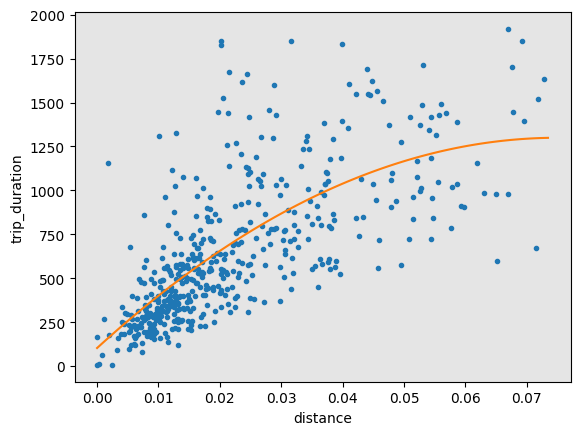

In [95]:
PlotPolly(func, df['distance'][:500], df['trip_duration'][:500], 'distance')

# Оценка качества моделей

- lr
- lasso_with_optuna
- ridge_with_optuna
- elastic_with_optuna


In [96]:
#

In [97]:
columns = pd.MultiIndex.from_tuples([
    ("Perpeccop", ""), 
    ("Train Data", "MAE"), ("Train Data", "MSE"), ("Train Data", "RMSE"), ("Train Data", "MAPE"), ("Train Data", "R²"),
    ("Test Data", "MAE"), ("Test Data", "MSE"), ("Test Data", "RMSE"), ("Test Data", "MAPE"), ("Test Data", "R²"),
])

# Создаем DataFrame с реальными числами
data = [
    ["Linear Regression"] + list(calc_test_train_scores_mn(lr)[0]) + list(calc_test_train_scores_mn(lr)[1]),
    ["Lasso"] + list(calc_test_train_scores_mn(lasso_with_optuna)[0]) + list(calc_test_train_scores_mn(lasso_with_optuna)[1]),
    ["Ridge"] + list(calc_test_train_scores_mn(ridge_with_optuna)[0]) + list(calc_test_train_scores_mn(ridge_with_optuna)[1]),
    ["ElasticNet"] + list(calc_test_train_scores_mn(elastic_with_optuna)[0]) + list(calc_test_train_scores_mn(elastic_with_optuna)[1]),
    ["Polynomial"] + list(calc_test_train_scores_mn(pipe)[0]) + list(calc_test_train_scores_mn(pipe)[1])
]

df = pd.DataFrame(data, columns=columns)

df

Perpeccop Train Data                                   Test Data  \
                            MAE        MSE     RMSE   MAPE     R²       MAE   
0  Linear Regression    215.919  82896.139  287.917  0.537  0.497   216.149   
1              Lasso    216.950  83146.186  288.351  0.547  0.495   217.133   
2              Ridge    215.919  82896.139  287.917  0.537  0.497   216.149   
3         ElasticNet    225.219  86573.778  294.234  0.623  0.474   225.325   
4         Polynomial    194.201  69671.916  263.954  0.434  0.577   194.120   

                                     
         MSE     RMSE   MAPE     R²  
0  83056.391  288.195  0.533  0.496  
1  83264.060  288.555  0.544  0.495  
2  83056.391  288.195  0.533  0.496  
3  86567.986  294.224  0.619  0.474  
4  68578.205  261.874  0.426  0.584

In [98]:
from my_scores2 import *

In [99]:
columns = pd.MultiIndex.from_tuples([
    ("Perpeccop", ""), 
    ("Scikit-learn", "MAE"), ("Scikit-learn", "MSE"), ("Scikit-learn", "RMSE"), ("Scikit-learn", "MAPE"), ("Scikit-learn", "R²"),
    ("Кастомные функции", "MAE"), ("Кастомные функции", "MSE"), ("Кастомные функции", "RMSE"), ("Кастомные функции", "MAPE"), ("Кастомные функции", "R²"),
])

# Создаем DataFrame с реальными числами
data = [
    ["Linear Regression"] + list(calc_test_train_scores_mn(lr)[0]) + list(calc_test_train_my_scores(lr, X_test, y_test)),
    ["Lasso"] + list(calc_test_train_scores_mn(lasso_with_optuna)[0]) + list(calc_test_train_my_scores(lasso_with_optuna, X_test, y_test)),
    ["Ridge"] + list(calc_test_train_scores_mn(ridge_with_optuna)[0]) + list(calc_test_train_my_scores(ridge_with_optuna, X_test, y_test)),
    ["ElasticNet"] + list(calc_test_train_scores_mn(elastic_with_optuna)[0]) + list(calc_test_train_my_scores(elastic_with_optuna, X_test, y_test)),
    ["Polynomial"] + list(calc_test_train_scores_mn(pipe)[0]) + list(calc_test_train_my_scores(pipe, X_test, y_test))
]

df = pd.DataFrame(data, columns=columns)

df

Perpeccop Scikit-learn                                    \
                              MAE        MSE     RMSE   MAPE     R²   
0  Linear Regression      215.919  82896.139  287.917  0.537  0.497   
1              Lasso      216.950  83146.186  288.351  0.547  0.495   
2              Ridge      215.919  82896.139  287.917  0.537  0.497   
3         ElasticNet      225.219  86573.778  294.234  0.623  0.474   
4         Polynomial      194.201  69671.916  263.954  0.434  0.577   

  Кастомные функции                                    
                MAE        MSE     RMSE   MAPE     R²  
0           215.919  82896.139  287.917  0.537  0.497  
1           216.950  83146.186  288.351  0.547  0.495  
2           215.919  82896.139  287.917  0.537  0.497  
3           225.219  86573.778  294.234  0.623  0.474  
4           194.201  69671.916  263.954  0.434  0.577

# Вывод

Лучше всего себя показывает полиномиальная модель. Видно, что все её метрики лучше, чем у остальных моделей. 

Модели Lasso, Ridge, ElasticNet делают веса меньше по сравнению с линейной регрессией.

Множественная модель точнее, чем простая. Она показывает лучшие показатели метрик.

Также были написаны собственные функции метрик. Значения совпадают с функциями из scikit-learn.

Переобучения у моделей не наблюдается. Метрики на тестовой и тренировочной выборках не сильно отличаются

## Визуализация

C:\Users\Denis\AppData\Local\Temp\ipykernel_22360\1638506269.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.distplot(y_test, hist=False, color='Red', label='Actual values')
C:\Users\Denis\AppData\Local\Temp\ipykernel_22360\1638506269.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns

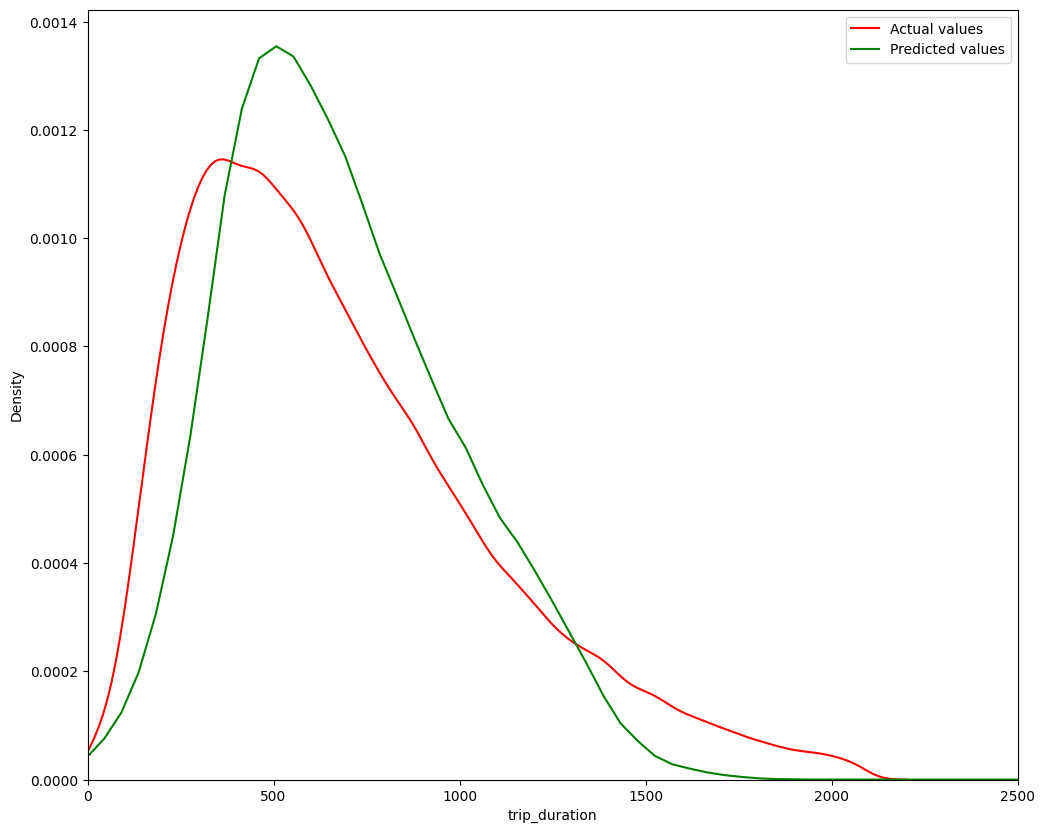

In [100]:
plt.figure(figsize=(12,10))
ax2 = sns.distplot(y_test, hist=False, color='Red', label='Actual values')
ax2.set_xlim(0, 2500)
sns.distplot(poly_pred, hist=False, color='Green', label='Predicted values')
ax2.legend()
plt.show()